# Week 23 | 4 June - 10 June 2018

In [1]:
#packages
import pandas as pd
import csv
import matplotlib as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
import glob
import pycountry
from datetime import datetime

#chaning the number of columns that are displayed. get will tell you how much. 
pd.set_option("display.max_columns",50)
sns.set_style("whitegrid")

pd.options.mode.chained_assignment = None

# 1. Performance per Country

In [2]:
### Cleaning

#importing Data
df_campaign=pd.read_excel("23_campaign.xlsx")

#dropping unused columns
df_campaign.drop(columns=["id","status","Rejection rate","maxleads","url","client_id","ap_campaign_id","ad_set_campaign_group_id",
                        "notification_stop_spend_threshold","margin_percentage","facebook_business_id","countryIso"], inplace=True)

#1. FIX CTR
def foo(x):
    if x["ctr"] >= 1:
        return(x["ctr"]/10000)
    else:
        return(x["ctr"])
df_campaign["ctr"] = df_campaign.apply(foo, axis=1)
df_campaign["ctr"] = df_campaign["ctr"].round(2)

#2. FIX CPC
def roo(x):
    if x["cpc"] >= 1 and x["cpc"] < 1000000:
        return(x["cpc"]/100000)
    if x["cpc"] >= 1000000:
        return(x["cpc"]/1000000)
    else:
        return(x["cpc"])
df_campaign["cpc"] = df_campaign.apply(roo, axis=1)
df_campaign["cpc"] = df_campaign["cpc"].round(2)

#3. FIX CPM
def coo(x):
    if x["cpm"] >= 1:
        return(x["cpm"]/1000000)
    else:
        return(x["cpm"])
df_campaign["cpm"] = df_campaign.apply(coo, axis=1)
df_campaign["cpm"] = df_campaign["cpm"].round(2)

#4. FIX CR
df_campaign["cr"] = df_campaign["cr"]/10000
df_campaign["cr"] = df_campaign["cr"].round(2)

#5. FIX CPA
def too(x):
    if x["cpa"] >= 1:
        return(x["cpa"]/1000000)
    else:
        return(x["cpa"])
df_campaign["cpa"] = df_campaign.apply(too, axis=1)
df_campaign["cpa"] = df_campaign["cpa"].round(2)

#6. FIX MARGIN_P
def woo(x):
    if x["purchase"] == 0 and x["revenue"] >= 1:
        return(100)
    if x["purchase"] == 0 and x["revenue"] == 0:
        return(0)
    if x["purchase"] > 0 and x["revenue"] == 0:
        return(-100)
    else:
        return((x["margin"]/x["revenue"])*100)
df_campaign["marginP"] = df_campaign.apply(woo, axis=1)
df_campaign["marginP"] = df_campaign["marginP"].round(2)

#7. COUNTRY NAMES
df_campaign["country"]=df_campaign["iso_code"].str.split("_").str[1]
def get_country_code(x):
    return pycountry.countries.get(alpha_2=x).name
df_campaign["country"] = df_campaign["country"].apply(get_country_code)
df_campaign.drop(columns=["iso_code"], inplace=True)

### 1.1 Margin % across countries

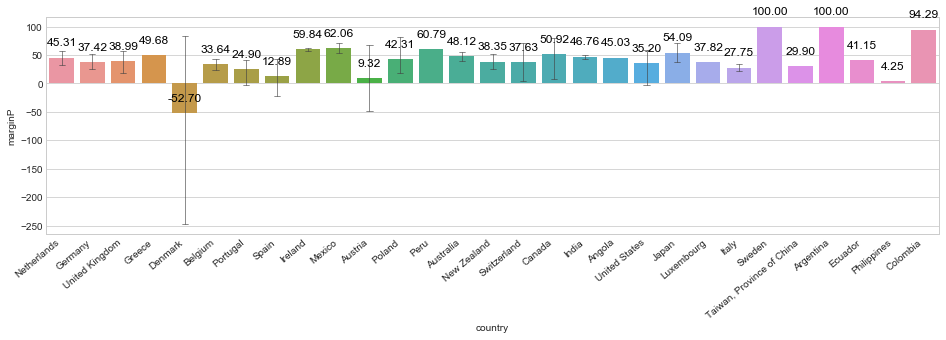

In [3]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="country", y="marginP", data=df_campaign, capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

In [4]:
#total by marketer
df_campaign['total']=1
df_country=df_campaign.groupby(by=['country']).sum()

### 1.2 Margin across countries

Keep in mind that each country is still in their "business" currency. I have found a way to convert them within the dataframe, but it will need a little more time before I can implement it. 

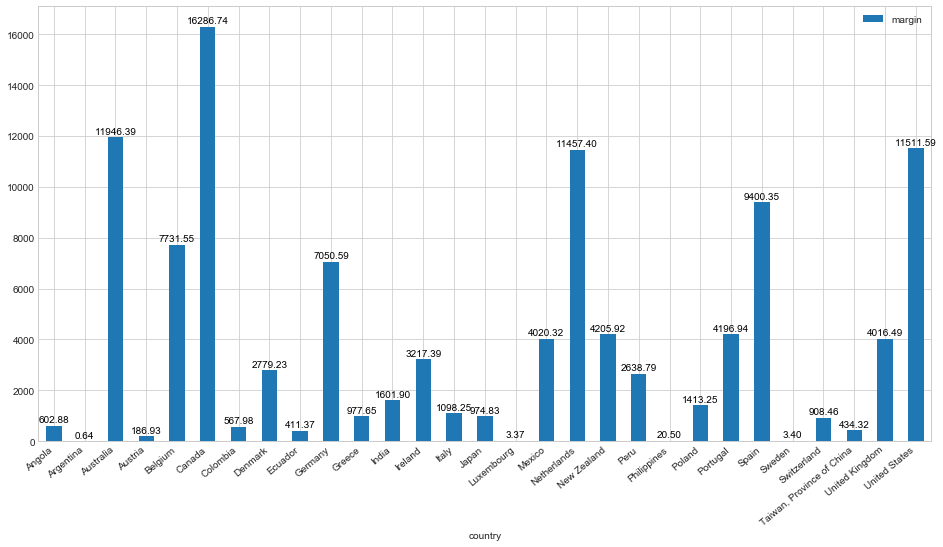

In [5]:
pa=df_country[["margin"]].plot(kind="bar", figsize=(16,8))
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=10, color="black", xytext=(0, 6),
                 textcoords="offset points")

Available variables Campaign Level:
    
    Categorical:
    -name
    -business_name
    -manager_name
    -ad_set_manager_id
    -client
    -notification_stop_spend
    -revenue_multiplier
    -currency
    -country
    -vertical
    
    Continuous:
    -leads
    -revenue
    -margin
    -cpc
    -cpm
    -cpa
    -clicks
    -views
    
    %:
    -marginP
    -ctr
    -cr

______

# 2. Performance per Marketer

### 2.1 Margin % of marketer's campaigns 

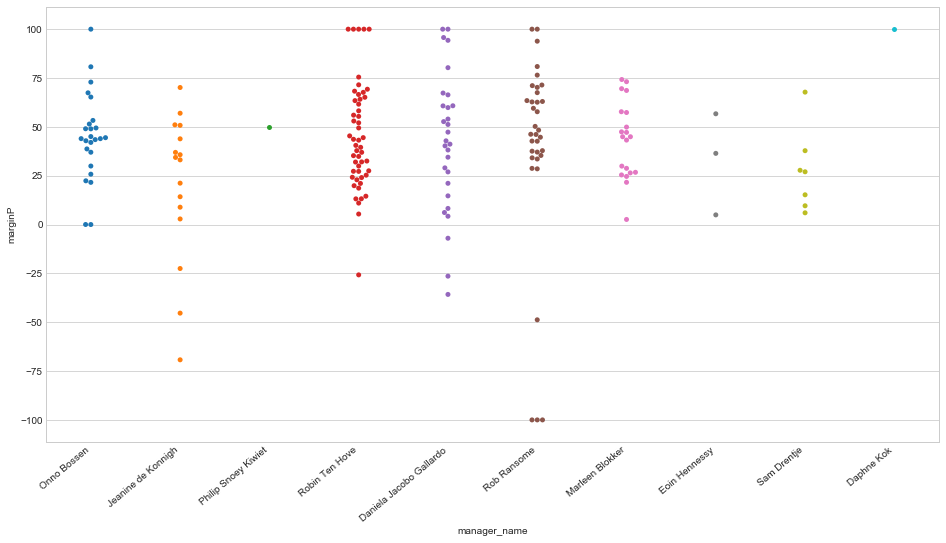

In [6]:
plt.pyplot.figure(figsize=(16,8))
ka=sns.swarmplot(x="manager_name", y="marginP", data=df_campaign.loc[df_campaign["marginP"]>=-100])
ka.set_xticklabels(ka.get_xticklabels(), rotation=40, ha="right")
ka

In [7]:
#total by marketer
df_marketer=df_campaign.groupby(by=['manager_name']).sum()

### 2.2 Margin made per Marketer

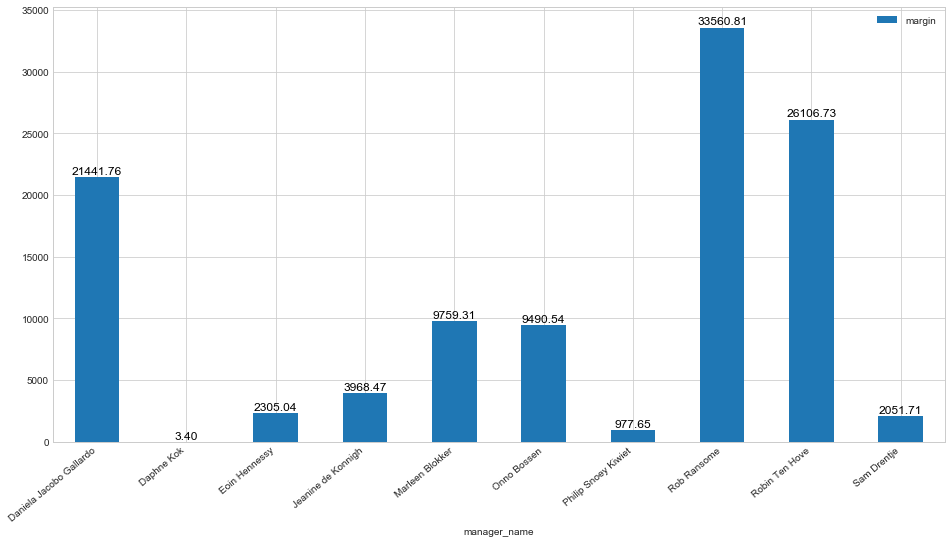

In [8]:
pa=df_marketer[["margin"]].plot(kind="bar", figsize=(16,8))
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 6),
                 textcoords="offset points")

### 2.3 Average margin per marketer

In [9]:
#creating new variable
df_marketer["average"]=df_marketer["margin"]/df_marketer["total"]

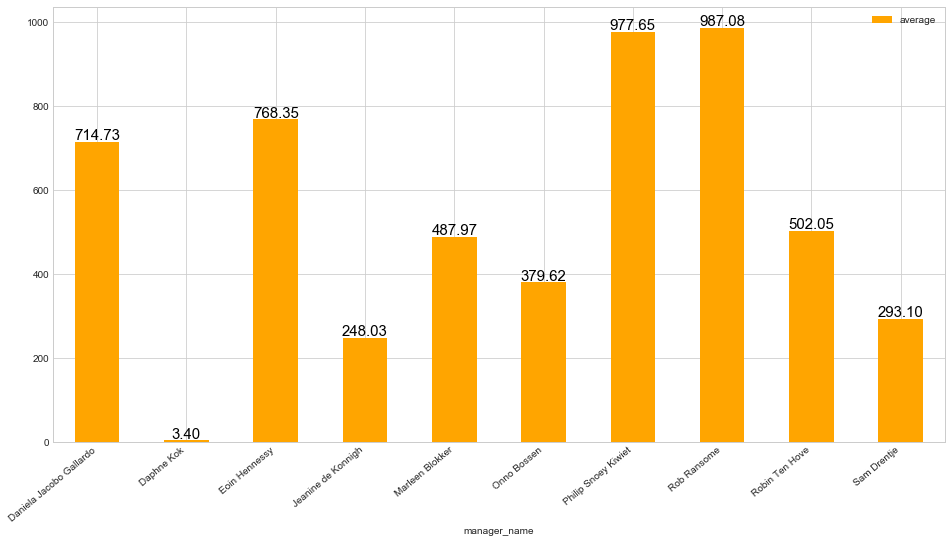

In [10]:
pa=df_marketer[["average"]].plot(kind="bar", figsize=(16,8), color="orange")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

________

# 3. Performance per Vertical

In [11]:
def yoo(x):
    if x["manager_name"]=="Onno Bossen" or x["manager_name"]=="Jeanine de Konnigh":
        return("other?")
    if x["manager_name"]=="Sam Drentje" or x["manager_name"]=="Marleen Blokker" or x["manager_name"]=="Daniela Jacobo Gallardo" or x["manager_name"]=="Daphne Kok":
        return("NGOs")
    if x["manager_name"]=="Philip Snoey Kiwiet" or x["manager_name"]=="Robin Ten Hove" or x["manager_name"]=="Rob Ransome" or x["manager_name"]=="Eoin Hennessy":
        return("hearing aids")
df_campaign["vertical"] = df_campaign.apply(yoo, axis=1)

### 3.1 Margin % per vertical

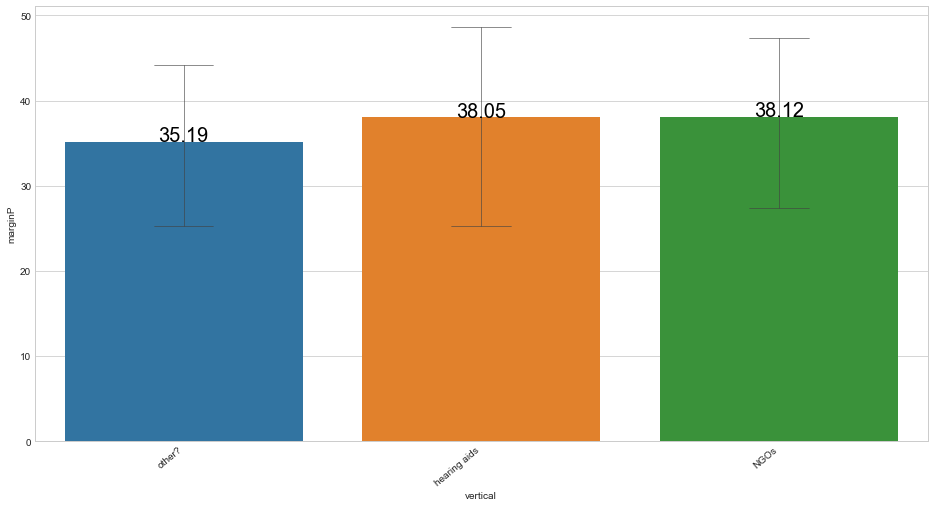

In [12]:
plt.pyplot.figure(figsize=(16,8))
pa=sns.barplot(x="vertical", y="marginP", data=df_campaign, capsize=.2, errwidth=.6)
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=20, color="black", xytext=(0, 6),
                 textcoords="offset points")

In [13]:
#total by vertical
df_vertical=df_campaign.groupby(by=['vertical']).sum()

### 3.2 Margin per vertical

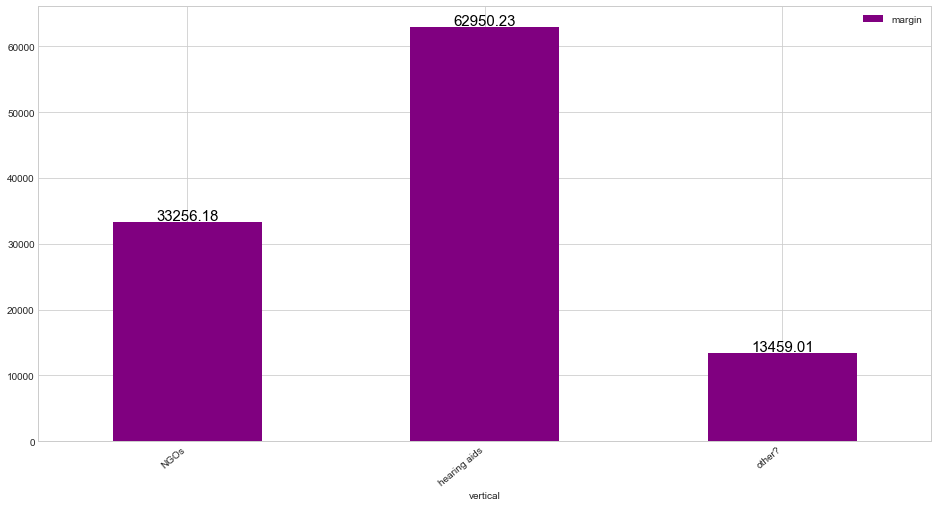

In [14]:
pa=df_vertical[["margin"]].plot(kind="bar", figsize=(16,8), color="purple")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

___________

# 4. Performance per Day of the Week

In [15]:
#importing multiple files using glob
#getting bert data
sheetnames=glob.glob("23__*.xlsx")
list_of_dfs = [pd.read_excel(sheet) for sheet in sheetnames]
for dataframe, sheet in zip(list_of_dfs, sheetnames):
    dataframe["day_num"] = sheet
df_daily = pd.concat(list_of_dfs, ignore_index=True) 

In [16]:
### Cleaning

#creating day of the week variable
df_daily["day_num"]=df_daily["day_num"].str.split("_").str[2]
def doo(x):
    if x["day_num"] == "1.xlsx":
        return("monday")
    if x["day_num"] == "2.xlsx":
        return("tuesday")
    if x["day_num"] == "3.xlsx":
        return("wednesday")
    if x["day_num"] == "4.xlsx":
        return("thursday")
    if x["day_num"] == "5.xlsx":
        return("friday")
    if x["day_num"] == "6.xlsx":
        return("saturday")
    else:
        return("sunday")
df_daily["day"] = df_daily.apply(doo, axis=1)

#dropping unused columns
df_daily.drop(columns=["id","status","ad_set_manager_id","client_id","ap_campaign_id","ad_set_campaign_group_id",
                      "notification_stop_spend","notification_stop_spend_threshold","margin_percentage",
                      "facebook_business_id","maxleads","countryIso","url"], inplace=True)

#1. FIX CTR
def foo(x):
    if x["ctr"] >= 1:
        return(x["ctr"]/10000)
    else:
        return(x["ctr"])
df_daily["ctr"] = df_daily.apply(foo, axis=1)
df_daily["ctr"] = df_daily["ctr"].round(2)

#2. FIX CPC
def roo(x):
    if x["cpc"] >= 1 and x["cpc"] < 1000000:
        return(x["cpc"]/100000)
    if x["cpc"] >= 1000000:
        return(x["cpc"]/1000000)
    else:
        return(x["cpc"])
df_daily["cpc"] = df_daily.apply(roo, axis=1)
df_daily["cpc"] = df_daily["cpc"].round(2)

#3. FIX CPM
def coo(x):
    if x["cpm"] >= 1:
        return(x["cpm"]/1000000)
    else:
        return(x["cpm"])
df_daily["cpm"] = df_daily.apply(coo, axis=1)
df_daily["cpm"] = df_daily["cpm"].round(2)

#4. FIX CR
df_daily["cr"] = df_daily["cr"]/10000
df_daily["cr"] = df_daily["cr"].round(2)

#5. FIX CPA
def too(x):
    if x["cpa"] >= 1:
        return(x["cpa"]/1000000)
    else:
        return(x["cpa"])
df_daily["cpa"] = df_daily.apply(too, axis=1)
df_daily["cpa"] = df_daily["cpa"].round(2)

#6. FIX MARGIN_P
def woo(x):
    if x["purchase"] == 0 and x["revenue"] >= 1:
        return(100)
    if x["purchase"] == 0 and x["revenue"] == 0:
        return(0)
    if x["purchase"] > 0 and x["revenue"] == 0:
        return(-100)
    else:
        return((x["margin"]/x["revenue"])*100)
df_daily["marginP"] = df_daily.apply(woo, axis=1)
df_daily["marginP"] = df_daily["marginP"].round(2)

#7. COUNTRY NAMES
df_daily["country"]=df_daily["iso_code"].str.split("_").str[1]
def get_country_code(x):
    return pycountry.countries.get(alpha_2=x).name
df_daily["country"] = df_daily["country"].apply(get_country_code)
df_daily.drop(columns=["iso_code"], inplace=True)

df_daily.drop(columns=["day_num"], inplace=True)

order=["monday","tuesday","wednesday","thursday","friday","saturday","sunday"]

Available variables Weekly Level:
    
    Categorical:
    -name
    -business_name
    -manager_name
    -client
    -revenue_multiplier
    -currency
    -day
    -country
    
    Continuous:
    -leads
    -revenue
    -purchase
    -margin
    -cpc
    -cpm
    -cpa
    -clicks
    -views
    
    %:
    -rejection rate
    -marginP
    -ctr
    -cr

### 4.1 Margin %

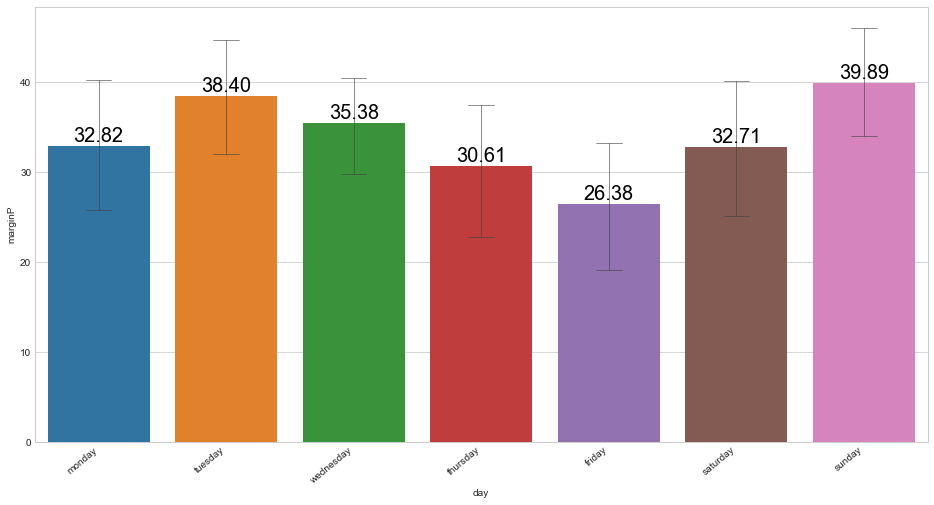

In [18]:
plt.pyplot.figure(figsize=(16,8))
pa=sns.barplot(x="day", y="marginP", data=df_daily, capsize=.2, order=order, errwidth=.6)
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=20, color="black", xytext=(0, 10),
                 textcoords="offset points")

### 4.2 cpa

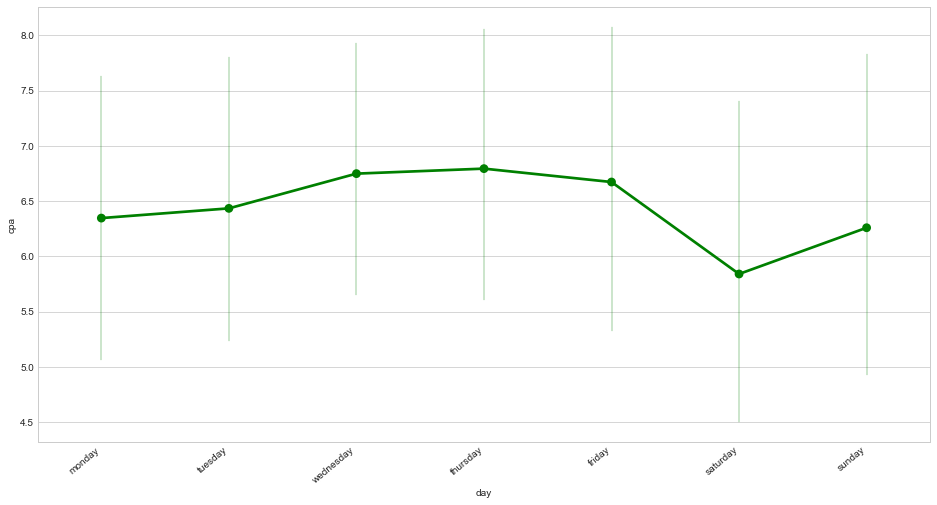

In [19]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cpa", data=df_daily, order=order, color="g", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

### 4.3 cpc

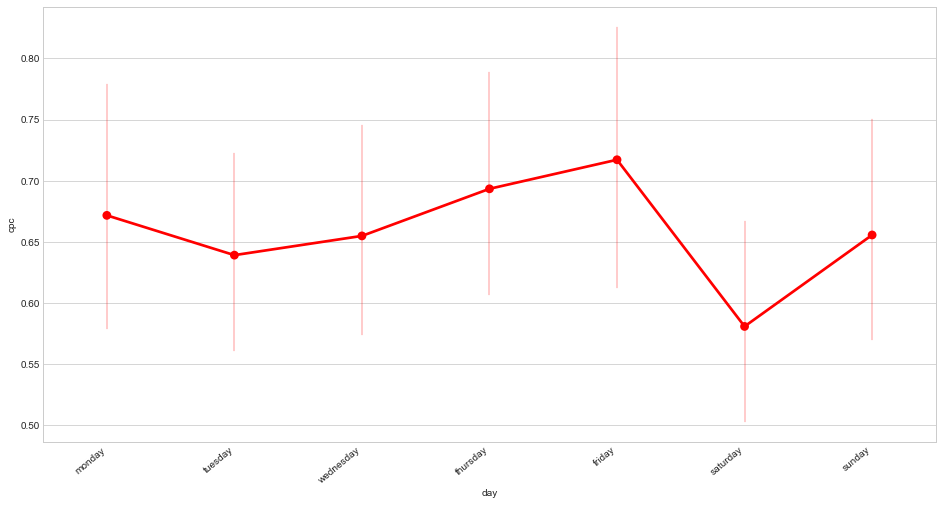

In [20]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cpc", data=df_daily, order=order, color="r", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

### 4.4 cpm

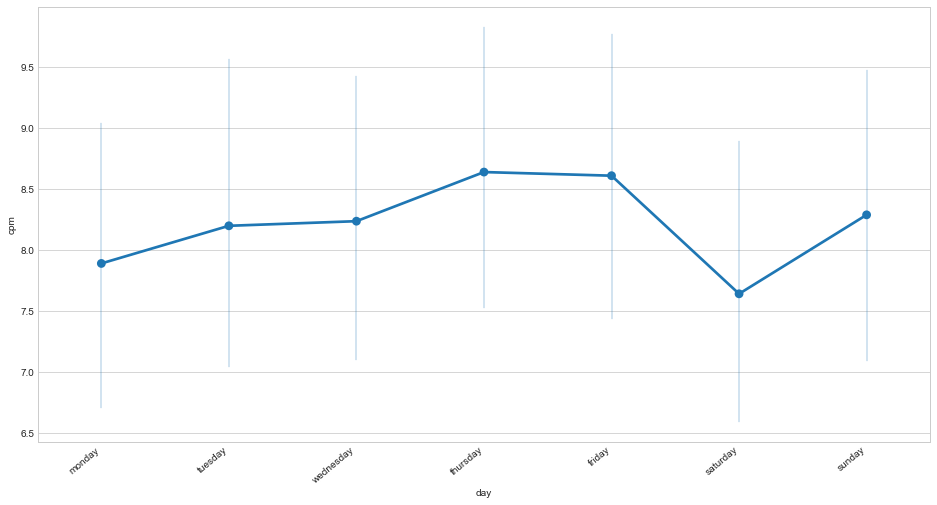

In [45]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cpm", data=df_daily, order=order, dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

### 4.5 cr

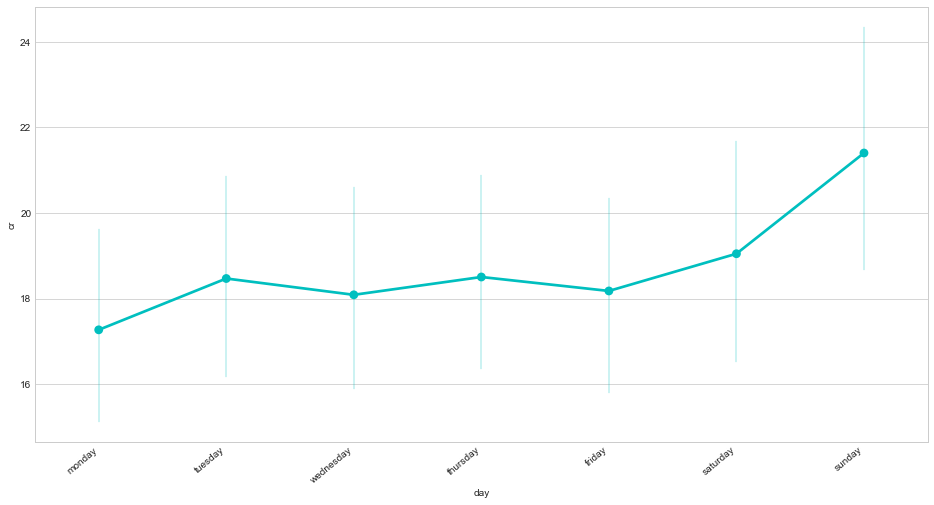

In [22]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cr", data=df_daily, order=order, color="c", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

### 4.6 ctr

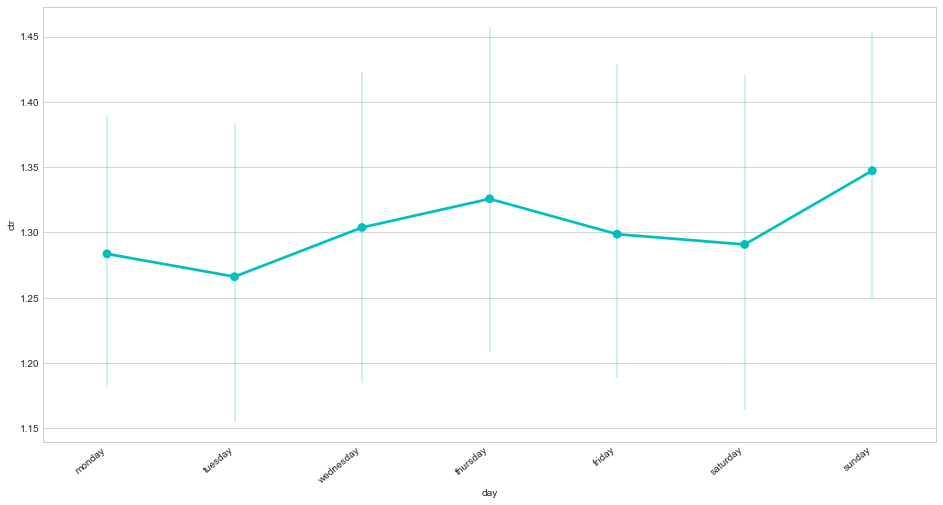

In [23]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="ctr", data=df_daily, order=order, color="c", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

_______

# 5. Top performing new ads

In [24]:
##### Cleaning

df_raw=pd.read_excel("23_newads.xlsx")

#subsetting data
df_newads=df_raw.loc[df_raw["insert_time"]>=datetime(2018,6,4)]

#dropping columns
df_newads.drop(columns=["id","status","real_budget","start_date","end_date","url","ad_set_campaign_id",
                       "margin_percentage","facebook_ad_set_id","facebook_ad_account_id","facebook_business_id",
                       "short_url","ad_url_domain_id"], inplace=True)

#1. FIX CTR
# no fix needed
df_newads["ctr"] = df_newads["ctr"].round(2)

#2. FIX CPC
def roo(x):
    if x["cpc"] >= 1 and x["cpc"] < 1000000:
        return(x["cpc"]/100000)
    if x["cpc"] >= 1000000:
        return(x["cpc"]/1000000)
    else:
        return(x["cpc"])
df_newads["cpc"] = df_newads.apply(roo, axis=1)
df_newads["cpc"] = df_newads["cpc"].round(2)

#3. FIX CPM
def coo(x):
    if x["cpm"] >= 1:
        return(x["cpm"]/1000000)
    else:
        return(x["cpm"])
df_newads["cpm"] = df_newads.apply(coo, axis=1)
df_newads["cpm"] = df_newads["cpm"].round(2)

#4. No fix for CR needed.

#5. FIX CPA
def too(x):
    if x["cpa"] >= 1:
        return(x["cpa"]/1000000)
    else:
        return(x["cpa"])
df_newads["cpa"] = df_newads.apply(too, axis=1)
df_newads["cpa"] = df_newads["cpa"].round(2)

#6. FIX MARGIN_P
def woo(x):
    if x["purchase"] == 0 and x["revenue"] >= 1:
        return(100)
    if x["purchase"] == 0 and x["revenue"] == 0:
        return(0)
    if x["purchase"] > 0 and x["revenue"] == 0:
        return(-100)
    else:
        return((x["margin"]/x["revenue"])*100)
df_newads["marginP"] = df_newads.apply(woo, axis=1)
df_newads["marginP"] = df_newads["marginP"].round(2)

Available variables new ads:
    
    Categorical:
    -tag
    -campaign_name
    -name
    -budget
    -relevance_score (?)
    -insert_time
    -revenue_type
    -currency
    -day
    -country
    
    Continuous:
    -leads
    -revenue
    -purchase
    -margin
    -cpc
    -cpm
    -cpa
    -frequency
    -clicks
    -views
    
    %:
    -rejection rate
    -marginP
    -ctr
    -cr

Potential questions/points for dataframes:

- What relevant variables do we want to see? What columns are important to look at? I have excluded a few below.
- How many values do we want displayed? 10, 20, 30..
- Do we want more 'short' dataframes? e.g. display the top 5 in margin, leads, cr, cpc etc
- It could be interesting to look at budgets here. Since these ads were only added during the week, it is likely (but not guaranteed) that the budgets were not changed



The table below shows new ads that had a margin % above 50%. They are displayed in descending order from highest margin to lowest (this will filter out ads with 100% margins that made very little money). 



In [25]:
df_newads.loc[df_newads['marginP']>=50].nlargest(10,'margin').drop(columns=["name","relevance_score","insert_time",
                                                                            "revenue_type","frequency"])

,tag,campaign_name,budget,leads,revenue,purchase,margin,ctr,cpc,cpm,cr,cpa,currency,marginP,views,clicks
2468,SB000000001151450,WWF CA,12.0,106,508.80,21.22,487.58,2.1,0.14,3.00,71.6,0.20,CAD,95.83,7063,148
2469,SB000000001151453,WWF CA,8.0,88,422.40,16.80,405.60,2.0,0.16,3.18,84.6,0.19,CAD,96.02,5283,104
2374,SB000000001150997,Blackberry Hearing,80.0,28,595.00,215.15,379.85,0.8,0.39,3.09,5.1,7.68,EUR,63.84,69538,554
2470,SB000000001151456,WWF CA,10.0,79,379.20,15.67,363.53,2.7,0.13,3.35,63.2,0.20,CAD,95.87,4674,125
2542,SB000000001152119,Schoonenberg - Luna 9 - QZ V5 - A,75.0,28,369.60,111.59,258.01,1.3,0.53,6.68,13.3,3.99,EUR,69.81,16709,210
2310,SB000000001150715,Victims Support NZ - Family Violence - Lead Ads,30.0,70,374.74,125.19,249.55,2.3,0.80,18.19,44.9,1.79,AUD,66.59,6882,156
2217,SB000000001150295,Ethiopiaid,65.0,85,408.00,168.83,239.17,3.4,0.79,26.63,39.7,1.99,AUD,58.62,6340,214
2473,SB000000001151480,AudicaoActiva PT - ReSound - Lead Ads - New,40.0,25,416.25,181.93,234.32,1.8,0.23,4.14,3.1,7.28,EUR,56.29,43946,805
2304,SB000000001150652,Connect Hearing - Hearing Studio - Lyric,40.0,13,286.00,52.68,233.32,2.8,1.01,28.26,25.0,4.05,EUR,81.58,1864,52
2306,SB000000001150661,Connect Hearing - Hearing Studio - Lyric,40.0,13,286.00,53.61,232.39,2.1,1.22,25.50,29.5,4.12,EUR,81.26,2102,44


.


e.g. this shows the top 10 margin (percentage) ads that had margins of over €150, ordered from highest conversion rate to lowest conversion rate.


In [26]:
df_newads.loc[df_newads['margin']>=150].nlargest(10,'marginP').sort_values(by='cr', ascending=False).drop(columns=["name","relevance_score","insert_time",
                                                                            "revenue_type","frequency"])

,tag,campaign_name,budget,leads,revenue,purchase,margin,ctr,cpc,cpm,cr,cpa,currency,marginP,views,clicks
2469,SB000000001151453,WWF CA,8.0,88,422.40,16.80,405.60,2.0,0.16,3.18,84.6,0.19,CAD,96.02,5283,104
2468,SB000000001151450,WWF CA,12.0,106,508.80,21.22,487.58,2.1,0.14,3.00,71.6,0.20,CAD,95.83,7063,148
2470,SB000000001151456,WWF CA,10.0,79,379.20,15.67,363.53,2.7,0.13,3.35,63.2,0.20,CAD,95.87,4674,125
2310,SB000000001150715,Victims Support NZ - Family Violence - Lead Ads,30.0,70,374.74,125.19,249.55,2.3,0.80,18.19,44.9,1.79,AUD,66.59,6882,156
2217,SB000000001150295,Ethiopiaid,65.0,85,408.00,168.83,239.17,3.4,0.79,26.63,39.7,1.99,AUD,58.62,6340,214
2306,SB000000001150661,Connect Hearing - Hearing Studio - Lyric,40.0,13,286.00,53.61,232.39,2.1,1.22,25.50,29.5,4.12,EUR,81.26,2102,44
2304,SB000000001150652,Connect Hearing - Hearing Studio - Lyric,40.0,13,286.00,52.68,233.32,2.8,1.01,28.26,25.0,4.05,EUR,81.58,1864,52
2542,SB000000001152119,Schoonenberg - Luna 9 - QZ V5 - A,75.0,28,369.60,111.59,258.01,1.3,0.53,6.68,13.3,3.99,EUR,69.81,16709,210
2374,SB000000001150997,Blackberry Hearing,80.0,28,595.00,215.15,379.85,0.8,0.39,3.09,5.1,7.68,EUR,63.84,69538,554
2473,SB000000001151480,AudicaoActiva PT - ReSound - Lead Ads - New,40.0,25,416.25,181.93,234.32,1.8,0.23,4.14,3.1,7.28,EUR,56.29,43946,805


______________

# 6. Campaigns that are dropping in margin from 45% + to below 45%

In [27]:
#importing new dataset
df_comp_raw=pd.read_excel("22_newads.xlsx")


####FOR WEEK BEFORE DF####


#dropping columns
df_comp_raw.drop(columns=["id","status","real_budget","start_date","end_date","url","ad_set_campaign_id",
                          "margin_percentage","facebook_ad_set_id","facebook_ad_account_id","facebook_business_id",
                          "short_url","ad_url_domain_id"], inplace=True)

#1. FIX CTR
#df_comp_raw["ctr"] = df_comp_raw.apply(foo, axis=1)
df_comp_raw["ctr"] = df_comp_raw["ctr"].round(2)

#2. FIX CPC
df_comp_raw["cpc"] = df_comp_raw.apply(roo, axis=1)
df_comp_raw["cpc"] = df_comp_raw["cpc"].round(2)

#3. FIX CPM
df_comp_raw["cpm"] = df_comp_raw.apply(coo, axis=1)
df_comp_raw["cpm"] = df_comp_raw["cpm"].round(2)

#4. No fix for CR needed.

#5. FIX CPA
df_comp_raw["cpa"] = df_comp_raw.apply(too, axis=1)
df_comp_raw["cpa"] = df_comp_raw["cpa"].round(2)

#6. FIX MARGIN_P
df_comp_raw["marginP"] = df_comp_raw.apply(woo, axis=1)
df_comp_raw["marginP"] = df_comp_raw["marginP"].round(2)



####FOR FULL RAW WEEK#####


#dropping columns
df_raw.drop(columns=["id","status","real_budget","start_date","end_date","url","ad_set_campaign_id",
                     "margin_percentage","facebook_ad_set_id","facebook_ad_account_id","facebook_business_id",
                     "short_url","ad_url_domain_id"], inplace=True)

#1. FIX CTR
#df_raw["ctr"] = df_raw.apply(foo, axis=1)
df_raw["ctr"] = df_raw["ctr"].round(2)

#2. FIX CPC
df_raw["cpc"] = df_raw.apply(roo, axis=1)
df_raw["cpc"] = df_raw["cpc"].round(2)

#3. FIX CPM
df_raw["cpm"] = df_raw.apply(coo, axis=1)
df_raw["cpm"] = df_raw["cpm"].round(2)

#4. No fix for CR needed.

#5. FIX CPA
df_raw["cpa"] = df_raw.apply(too, axis=1)
df_raw["cpa"] = df_raw["cpa"].round(2)

#6. FIX MARGIN_P
df_raw["marginP"] = df_raw.apply(woo, axis=1)
df_raw["marginP"] = df_raw["marginP"].round(2)


#####SLIMMING COMB DATA DOWN TO ONLY INCLUDE MARGINS ABOVE 45%###########
df_comp=df_comp_raw.loc[df_comp_raw["marginP"]>=45]

####COMBING DATA SETS########
df_452=df_comp.merge(df_raw, how ="inner", on = ["tag"])

df_45=df_452.loc[df_452["marginP_y"]<45]

The number of ads that dropped below 45%: 

In [28]:
len(df_45)

411

In [35]:
#making difference variable
df_45["diff_mP"]=df_45["marginP_x"]-(df_45["marginP_y"])
df_45["diff_m"]=df_45["margin_x"]-(df_45["margin_y"])

In [37]:
df_45vis = df_45[["tag","campaign_name_x","name_x","diff_mP","diff_m","marginP_x","marginP_y","margin_x","margin_y","ctr_x",
                  "ctr_y","cpm_x","cpm_y","cr_x","cr_y","cpa_x","cpa_y"]]

These are the 10 ads that lost the largest amount of money between the two weeks (i.e. Week 22 and Week 23). 
Here we can compare the other variables a bit easier as well.

_x = week 22

_y = week 23

In [42]:
df_45vis.nlargest(10,"diff_m")#.sort_values(by='diff_m', ascending=False)

,tag,campaign_name_x,name_x,diff_mP,diff_m,marginP_x,marginP_y,margin_x,margin_y,ctr_x,ctr_y,cpm_x,cpm_y,cr_x,cr_y,cpa_x,cpa_y
139,SB000000001121132,Save the Children IN - English speaking cities...,T3 IB M/V 30+ ALL ‚Äì CONTEXT 1,11.32,527.21,48.76,37.44,667.79,140.58,0.8,0.6,1.18,0.99,19.9,18.8,0.73,0.83
150,SB000000001122677,Blackberry Hearing,T4 I C Feb T M/V 50+ M/D copy,42.55,517.02,50.29,7.74,544.97,27.95,0.6,0.6,8.37,8.30,12.8,6.8,10.56,19.61
419,SB000000001141214,Belsono - Hearing Health Free Evaluation,T4 I SB April H M/F 50+ ALL,59.90,426.49,72.97,13.07,505.16,78.67,1.5,1.5,21.32,25.99,18.0,6.7,8.14,26.17
320,SB000000001138289,HelloFresh BEFR - Kookenqu√™te Nespresso,T 7 V SB May1 LP M/F 23+ ALL,6.97,420.16,50.99,44.02,893.41,473.25,1.0,0.9,4.25,4.43,37.9,35.6,1.18,1.34
488,SB000000001144196,Belsono - Hearing Health Free Evaluation,T5 V SB April B M/F 50+ ALL LAL 10% CV,84.69,420.07,64.81,-19.88,390.15,-29.92,2.2,1.3,23.51,26.45,10.3,5.6,10.59,36.08
552,SB000000001145783,HelloFresh BENL - Pizza Quiz,T 6 V SB May3 T M/F 23+ ALL,22.61,398.58,53.61,31.00,585.40,186.82,1.2,0.9,2.73,3.08,24.2,23.6,0.97,1.45
319,SB000000001138277,HelloFresh BEFR - Kookenqu√™te Nespresso,T 7 V SB mar2 FP M/F 23+ ALL,9.88,375.05,48.12,38.24,749.47,374.42,1.0,0.9,3.91,4.35,31.8,33.0,1.25,1.48
142,SB000000001121267,Save the Children IN - English speaking cities...,T3 IB M/V 30+ ALL ‚Äì CONTEXT 1 5% LAL Verzonden,14.19,356.00,55.71,41.52,481.13,125.13,1.0,0.8,1.04,1.00,16.4,15.9,0.63,0.77
138,SB000000001120931,AudioNova BEFR - White label IIC,T 3 V SB Mar2 A M/F 50+ ALL,36.32,355.23,47.23,10.91,419.37,64.14,1.0,1.0,8.90,9.11,13.8,8.1,6.33,10.69
144,SB000000001121273,Save the Children IN - English speaking cities...,T1 IB M/V 30+ ALL ‚Äì CONTEXT 1,19.48,339.92,51.33,31.85,408.20,68.28,0.5,0.5,0.82,0.98,24.1,21.4,0.69,0.90


x = week 22 | y = week 23

______

In [43]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>